# Random walk predictions model

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np

setup_notebook()

In [2]:
from datasets.stocks_data_wrapper import StocksDataWrapper

DATA_PATH = '../data/'
quotation = 'AAPL'
price_column = 'Close'

data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quotation}.txt")

### Data loading and plots

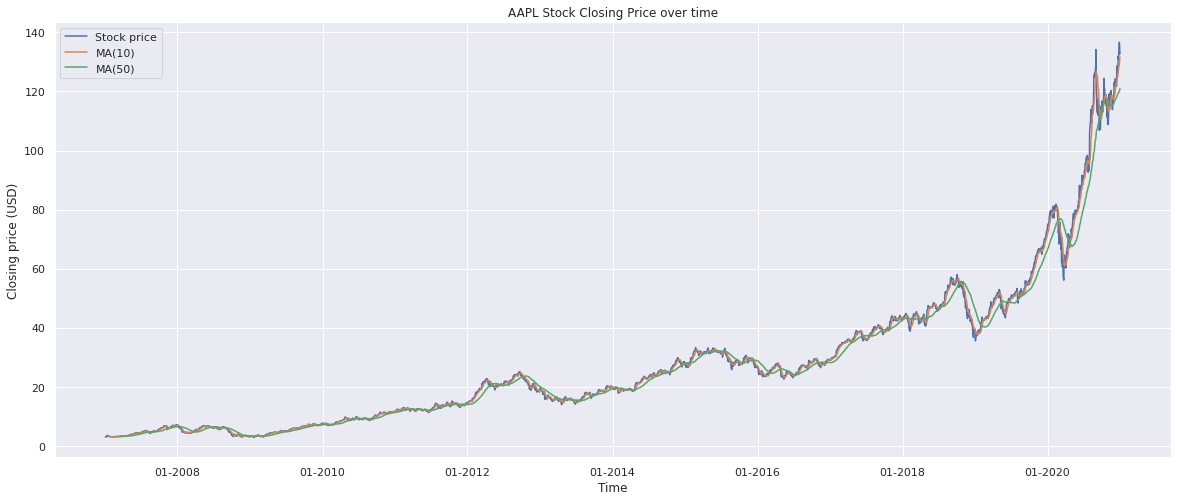

In [3]:
from helpers.plots_helper import plot_prices

ax = plot_prices(data_wrapper['Date'], data_wrapper[price_column], quotation_name=quotation, ma_values=[10,50])

### Stock price daily absolute difference 

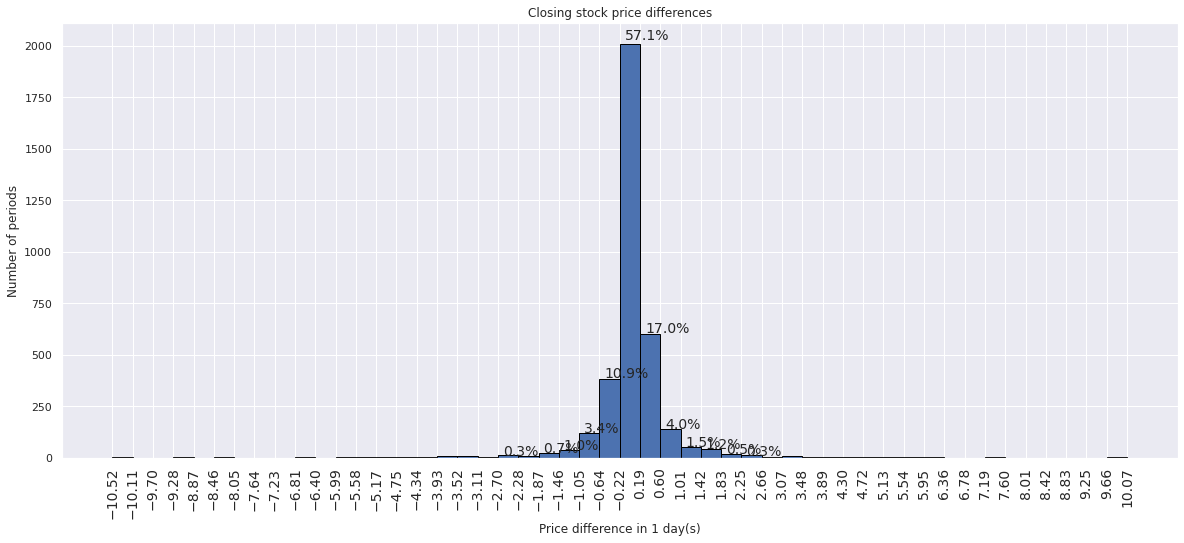

In [4]:
from helpers.plots_helper import plot_density_hist
data_wrapper['Difference'] = data_wrapper[price_column].diff(periods=1)
ax = plot_density_hist(data_wrapper['Difference'])

### Percentage stock price difference

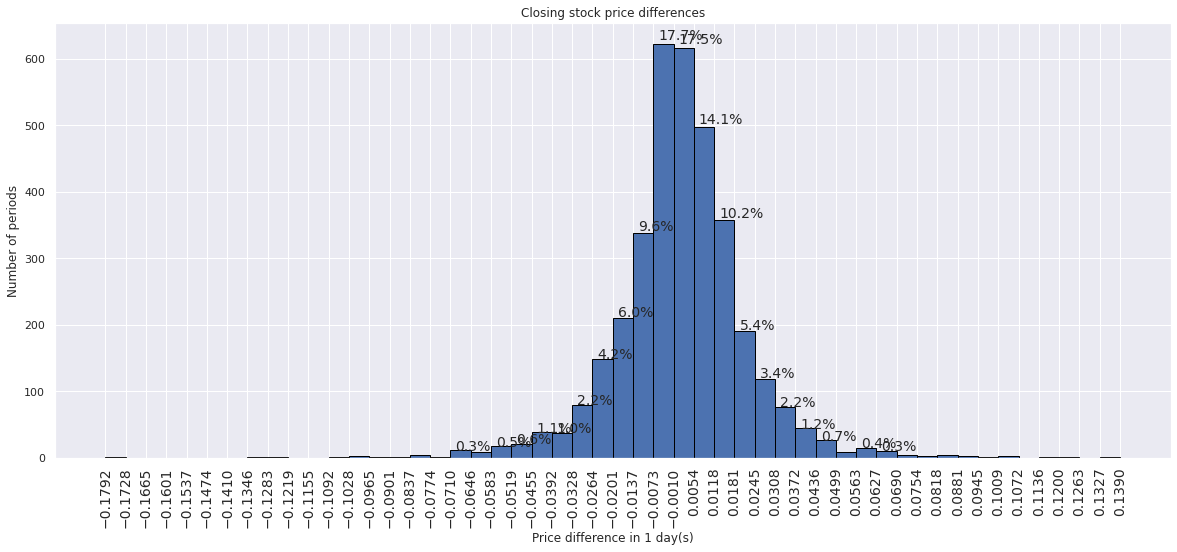

In [5]:
from helpers.plots_helper import plot_density_hist
data_wrapper['DiffPercent'] = data_wrapper[price_column].pct_change(periods=1)
ax = plot_density_hist(data_wrapper['DiffPercent'])

### Daily price tendency

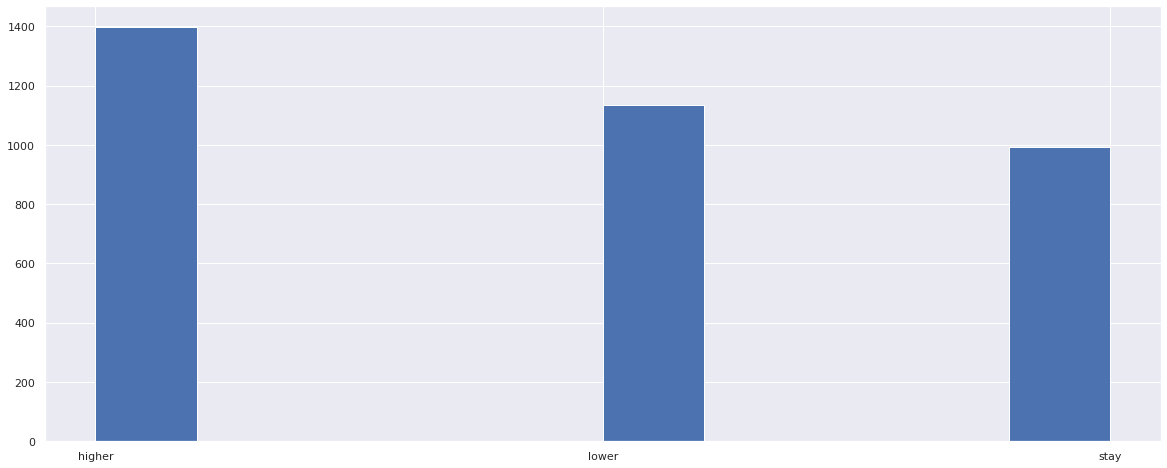

In [6]:
from helpers.data_helper import compute_tendency
from helpers.plots_helper import plot_normalized_histogram

data_wrapper['Tendency'] = compute_tendency(data_wrapper[price_column], percentage=True, thresh_diff=0.005)

ax = data_wrapper['Tendency'].hist()

### Random walk model

In [7]:
import random

random.seed(42)

# create the walk and price changes sequence
price_walk = []
for direction, count in data_wrapper['Tendency'].value_counts().to_dict().items():
    # filter the dataset by the current direction chosen
    df_filtered_direction = data_wrapper[data_wrapper['Tendency'] == direction]
    
    # pick at random some prices according to the current price direction chosen
    price_diffs = np.random.choice(df_filtered_direction['Difference'], size=count, replace=True)
    
    price_walk.extend([(direction, diff) for diff in price_diffs])
    
random.shuffle(price_walk)

print(price_walk[:10])

[('lower', -1.182495000000003), ('lower', -0.1875), ('lower', -0.6160719999999991), ('higher', 0.09250000000000025), ('lower', -0.13535699999999995), ('higher', 0.21499999999999986), ('lower', -0.14750000000000085), ('higher', 0.05750000000000011), ('higher', 0.22999999999999687), ('stay', 0.08821299999999965)]


In [8]:
import tqdm

prices = [data_wrapper[price_column].values[0]]

for direction, diff in price_walk: 
    prices.append(prices[-1] + diff)
    
print(len(prices))

3525


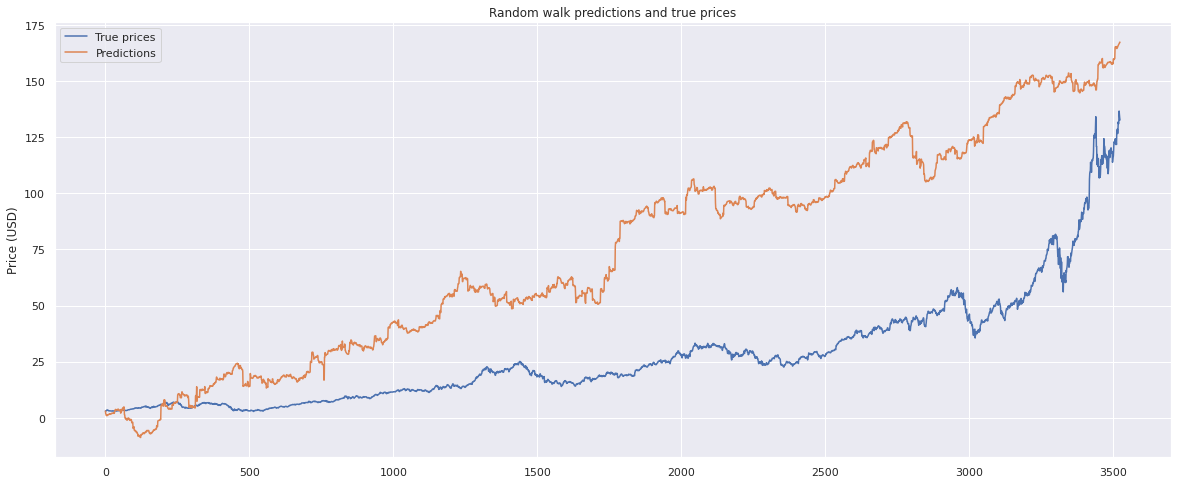

In [9]:
from helpers.plots_helper import plot_predictions

ax = plot_predictions(data_wrapper[price_column], prices, title="Random walk predictions and true prices")

In [10]:
from sklearn.metrics import mean_squared_error

print(f"MSE : {mean_squared_error(prices, data_wrapper[price_column]):.2f}")

MSE : 2989.35


### Random walk (direction only)

In [11]:
from collections import Counter

actual_directions = data_wrapper['Tendency']
# sample randomly the directions
random_directions = actual_directions.sample(frac=1).reset_index()


# could do better with pandas and sklearn didnt find how yet
acc_count = 0
for random_val, actual in zip(random_directions.Tendency, actual_directions.values):
    #print(f"Random : {random_val}, actual : {actual}")
    if random_val == actual:
        acc_count += 1
        
accuracy = acc_count / float(len(actual_directions))

print(f"Accuracy score : {accuracy*100:.1f}%")

Accuracy score : 34.0%
